# Nonparametric testing

In [169]:
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import pandas as pd
import statsmodels.api as sm
import statistics
import os 
from scipy.stats import norm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from numpy.random import randn
import plotly.express as px

## Comparing parametric and non-parametric testing

To compare parametric and non-parametric testing, lets go back to the example counting white blood cells.

In [133]:
dat = pd.read_csv('https://raw.githubusercontent.com/BiAPoL/Bio-image_Analysis_with_Python/main/biostatistics/data/leukocyte_counts.csv')

print(dat)

        healthy      COVID19          CLL
0   8112.953628  7938.261511  7995.138663
1   8049.767571  8815.331615  7169.552971
2   8092.332735  7830.310038  6780.272875
3   7498.168785  6240.226527  9962.335281
4   7143.005306  7745.239515  7786.586473
..          ...          ...          ...
95  7034.384604  6599.861270  6572.275825
96  7745.826977  8654.514650  8934.513929
97  8604.575198  8732.430100  7879.404564
98  7131.230127  7676.868854  7464.286189
99  7734.212640  7591.721753  6862.094897

[100 rows x 3 columns]


<AxesSubplot:>

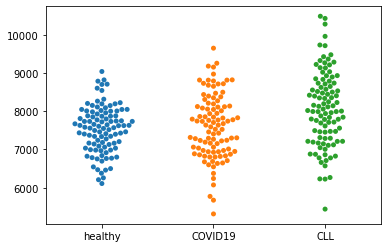

In [134]:
sns.swarmplot(data=dat)

Now to compare healthy with COVID19 we are doing a t-test that compares the mean. 

In [135]:
st.ttest_ind(dat['healthy'],dat['COVID19'])

Ttest_indResult(statistic=-0.6672986139650978, pvalue=0.5053583624156102)

The assumption of equal standard deviation was however violated for this test, so maybe we should have taken a non-parametric test?

In [136]:
st.wilcoxon(dat['healthy'],dat['COVID19'])

WilcoxonResult(statistic=2332.0, pvalue=0.506948473287772)

How about the difference healthy-CLL?

In [137]:
st.ttest_ind(dat['healthy'],dat['CLL'])

Ttest_indResult(statistic=-4.695380523297982, pvalue=4.964171715705624e-06)

In [138]:
st.wilcoxon(dat['healthy'],dat['CLL'])

WilcoxonResult(statistic=1283.0, pvalue=1.9512317174970406e-05)

Our p-value is one order of magnitude larger. Why is that?

Wilcoxon is comparing the ranks, so some information is lost, which frequently leads to loss of power. What is actually compared? Lets take the ranks.

        0      1
0   136.0  124.0
1   133.0   48.0
2   135.0   20.0
3    76.0  197.0
4    44.0  104.0
..    ...    ...
95   36.0   13.0
96  100.0  181.0
97  166.0  114.0
98   43.0   72.0
99   96.0   27.0

[100 rows x 2 columns]


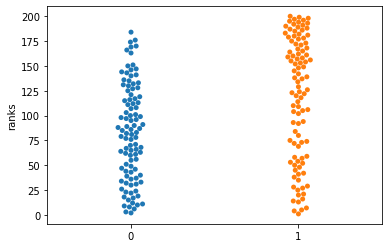

In [146]:
df4 = st.rankdata(dat[['healthy','CLL']]).reshape(100,2)

sns.swarmplot(data=df4)
plt.ylabel("ranks")

df2 = pd.DataFrame(df4)

print(df2)

## ANOVA

Now we have three samples, so a t-test is actually not appropriate. If we state the 0-Hypothesis that there is no difference between samples, we should apply a one-way ANOVA.

<AxesSubplot:>

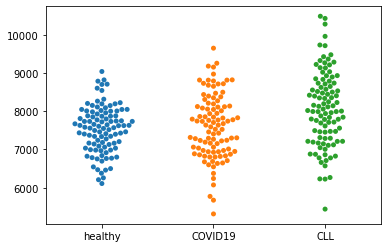

In [147]:
sns.swarmplot(data=dat)

In [148]:
st.f_oneway(dat['healthy'],dat['COVID19'],dat['CLL'])

F_onewayResult(statistic=12.847664465933143, pvalue=4.452663722900786e-06)

Now we know that we can reject H0 that there is no difference between the means in this case

How does this look for a non-parametric situation?

## Comparing Kruskal-Wallis with ANOVA

        0      1      2
0   208.0  183.0  191.0
1   202.0  267.0   81.0
2   206.0  170.0   33.0
3   122.0   10.0  297.0
4    75.0  155.0  163.0
..    ...    ...    ...
95   64.0   21.0   20.0
96  156.0  254.0  276.0
97  251.0  261.0  179.0
98   74.0  143.0  118.0
99  149.0  131.0   46.0

[100 rows x 3 columns]


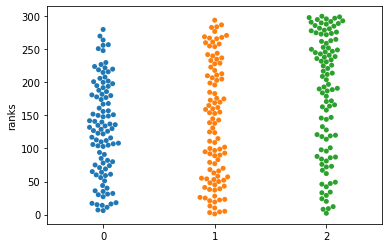

In [150]:
df4 = st.rankdata(dat).reshape(100,3)

sns.swarmplot(data=df4)
plt.ylabel("ranks")

df2 = pd.DataFrame(df4)

print(df2)

In [149]:
st.kruskal(dat['healthy'],dat['COVID19'],dat['CLL'])

KruskalResult(statistic=20.514054485049883, pvalue=3.5109906089968794e-05)

As before, we are loosing a bit of power. From the ranking plot, it becomes especially clear that we are looking at all comparisons at the same time.... but we really want to know which one makes the difference! But here we need to include Multiple testing correction!

## Multiple testing correction

For ANOVA there is Tukey. For non-parametric tests, there is Dunn's test. 

In [151]:
# For Tukey the dataframe needs to be melted
melted = pd.melt(dat)
print(melted)

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=melted['value'], groups=melted['variable'], alpha=0.05)
print(m_comp)

    variable        value
0    healthy  8112.953628
1    healthy  8049.767571
2    healthy  8092.332735
3    healthy  7498.168785
4    healthy  7143.005306
..       ...          ...
295      CLL  6572.275825
296      CLL  8934.513929
297      CLL  7879.404564
298      CLL  7464.286189
299      CLL  6862.094897

[300 rows x 2 columns]
    Multiple Comparison of Means - Tukey HSD, FWER=0.05    
 group1  group2  meandiff p-adj    lower     upper   reject
-----------------------------------------------------------
    CLL COVID19 -475.5107  0.001 -751.2353  -199.786   True
    CLL healthy -545.0705  0.001 -820.7951 -269.3458   True
COVID19 healthy  -69.5598 0.8042 -345.2845  206.1648  False
-----------------------------------------------------------


Also in these tests the individual comparisons are not independent, which makes them very suitable for moderately multiple testing correction.  
When going "big", Bonferroni and Benjamini-Hochberg are more custom, which for the former just correct by the total numbers of comparisons and for the latter adjust the false discovery rate (FDR).

## Correlation statistics 

In [ ]:
Because I am lagging the creativity at the moment to make good relatable data, lets simulate some randomly:

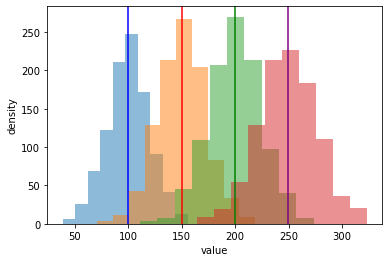

In [159]:
s1 = 20 * randn(1000) + 100
s2 = s1+ (10 * randn(1000) + 50)
s3 = s2+ (10 * randn(1000) + 50)
s4 = s3+ (10 * randn(1000) + 50)

plt.hist(s1,alpha=0.5)
plt.hist(s2,alpha=0.5)
plt.hist(s3,alpha=0.5)
plt.hist(s4,alpha=0.5)

plt.xlabel("value")
plt.ylabel("density")
plt.axvline(statistics.mean(s1), color="blue")
plt.axvline(statistics.mean(s2), color="red")
plt.axvline(statistics.mean(s3), color="green")
plt.axvline(statistics.mean(s4), color="purple")


This plot shows us that they are reasonably normally distributed.  
These data are now matched - information we are loosing with this visualisation!

<AxesSubplot:xlabel='s1', ylabel='s2'>

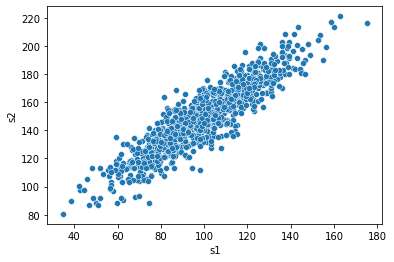

In [155]:
df = pd.DataFrame({'s1':s1, 's2':s2})
sns.scatterplot(x=df['s1'],y=df['s2'])

And with a regression line + confidence intervals

<AxesSubplot:xlabel='s1', ylabel='s2'>

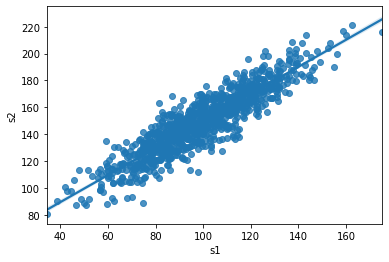

In [156]:
sns.regplot(x=df['s1'],y=df['s2'])

Because we can assume normal distribution for each of the dimensions separately, Pearson correlation is an appropriate correlation statistic. 

In [162]:
st.pearsonr(x=df['s1'],y=df['s2'])

(0.9030186240854189, 0.0)

Although here we do not have to use non-parametric statistics, lets have a look how it perfroms with Spearman.

How do the data look like, if we consider ranks?

<AxesSubplot:xlabel='0', ylabel='1'>

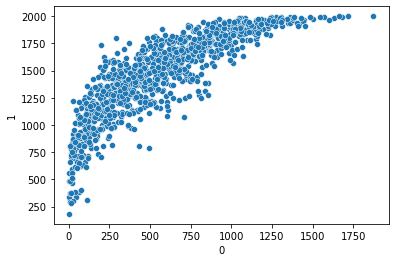

In [168]:
df4 = st.rankdata(df[['s1','s2']]).reshape(1000,2)
df4 = pd.DataFrame(df4)
sns.scatterplot(x=df4[0],y=df4[1])

Here you can already see that the ranks do not look random....

In [163]:
st.spearmanr(a=df['s1'],b=df['s2'])

SpearmanrResult(correlation=0.8917214077214076, pvalue=0.0)

What to do with multiple dimensions?

In [174]:
df = pd.DataFrame({'s1':s1, 's2':s2,'s3':s3, 's4':s4})
px.scatter_matrix(df)

Exercise: How do these samples relate to each other? Can you use the correlation as a measure to group them and visualise their relationship in a heatmap for example?  
How does the correlation relate to whether the distributions are different? How are they connected?